## Number of Smoke Waves Each Year

We defined smoke waves as the number of instances of 2 consecutive days over 9 μg/m3 wildfire PM2.5

In [1]:
import numpy as np
import numpy.ma as ma
import os
from datetime import datetime, timedelta 
import csv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

In [2]:
current_directory = os.path.dirname(os.getcwd())

In [3]:
# Number of Smoke Waves
relative_path = "Output/WFS_M5_smoke_wave_max_length.csv"
grouped_data_path = os.path.join(current_directory, relative_path)
smoke_waves = pd.read_csv(grouped_data_path)

# Census Tracts Shapefile
relative_sf_path = "Raw_Data/Shapefiles/Tracts2020_Adjusted.shp"
grouped_data_CT_path = os.path.join(current_directory, relative_sf_path)
Tracts2020 = gpd.read_file(grouped_data_CT_path)
Tracts2020 = Tracts2020.to_crs(epsg=3338) # NAD AK Albers projection (better to project maps of AK only)

# Maps Output Folder Path
output_folder = os.path.join(current_directory, "Output")

## Data Visualization

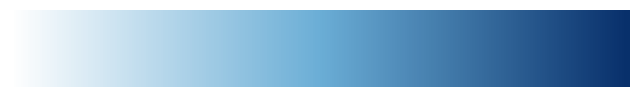

In [4]:
# Define colors: White -> Bright Blue -> Deep Dark Blue
colors = ["white", "#6BAED6", "#08306B"]  # Midpoint = Bright Blue, Endpoint = Dark Blue
WhiteToBlue = mcolors.LinearSegmentedColormap.from_list("WhiteToBlue", colors)

# Test the colormap with a gradient
gradient = np.linspace(0, 1, 256).reshape(1, -1)

fig, ax = plt.subplots(figsize=(8, 1))
ax.imshow(gradient, aspect="auto", cmap=WhiteToBlue)
ax.set_axis_off()
plt.show()

In [5]:
# Merge the data based on the common column
merged_data = Tracts2020.merge(smoke_waves, left_on='NAME', right_on='NAME', how='inner')

## Cumulative Map

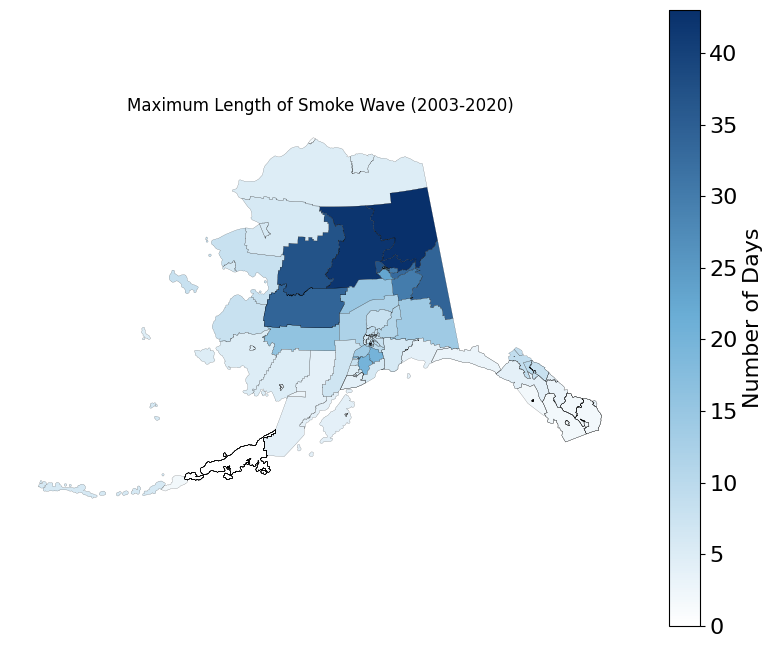

In [6]:
# Set up Albers Equal Area projection and create the figure and axis
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
fig, ax = plt.subplots(subplot_kw={'projection': alaska_albers}, figsize=(10, 8))

# Define the minimum and maximum values for color scaling
vmin = 0
vmax = merged_data['LongestWave'].max()

# Plot the boundaries and fill data with color based on 'Days in Longest Wave'
merged_data.boundary.plot(ax=ax, color='black', linewidth=0.10, transform=alaska_albers)
plot = merged_data.plot(
    ax=ax, column='LongestWave', cmap=WhiteToBlue, transform=alaska_albers, legend=True, vmin=vmin, vmax=vmax
)

# Colorbar label text sizing
cbar = plot.get_figure().get_axes()[-1] 
cbar.set_ylabel("Number of Days", fontsize=16)  # Increase title size
cbar.tick_params(labelsize=16)  # Increase tick label size

# Remove axis labels and ticks for a cleaner map display
ax.axis('off')

# Draw the figure to ensure everything is properly rendered
plt.draw()

# Export the image, ensuring tight layout so the colorbar isn't cut off
output_file_path = f"{output_folder}/WFS_M5_Cummulative.png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

# Set the map title
ax.set_title("Maximum Length of Smoke Wave (2003-2020)")

# Export the image, ensuring tight layout so the colorbar isn't cut off
output_file_path = f"{output_folder}/WFS_M5_Cummulative_Titled.png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

# Show the figure in the notebook
plt.show()

In [7]:
# Pivot the dataframe
pivoted_data = merged_data.pivot_table(
    index='NAME',        # Rows will be unique community names
    columns='Year',      # Columns will be unique years
    values='LongestWave' # Values will be the longest smoke wave lengths
)

# Rename the columns for clarity (optional)
pivoted_data.columns.name = None  # Remove the name of the columns index
pivoted_data.reset_index(inplace=True)  # Optional: reset index for cleaner display

# Replace NaN values with 0
pivoted_data.fillna(0, inplace=True)

# Replace NaN with 0
pivoted_data.fillna(0, inplace=True)

# Convert all numerical columns to integers
for col in pivoted_data.columns[1:]:  # Skip the first column (e.g., 'NAME')
    pivoted_data[col] = pivoted_data[col].astype(int)

pivoted_data

,NAME,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Abbott Loop,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0
1,Abbott Loop North,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0
2,Abbott Loop West,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0
3,Airport Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0
4,Airport Way Central,0,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Wonder Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0
173,Woodland Park/Spenard,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0
174,Wrangell,0,2,0,0,0,0,0,0,2,0,0,0,0,2,0,2,0,0
175,Yakutat,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0


## Annual Maps

In [8]:
# Define the Albers Equal Area projection
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)

# Define Years
years = range(2003, 2021) 

# Merge the census data with the entire WFS_M5_Year_Tract
WFS_M5_Annual_Tract_wGeo = Tracts2020.merge(pivoted_data, on='NAME', how='inner')

# Set vmin and vmax based on the overall data
vmin = 0
vmax = WFS_M5_Annual_Tract_wGeo[years].max().max()  # Find the overall maximum across all years

# Generate tick positions for colorbar
ticks = np.arange(0, vmax + 10, 10)

# Iterate over each year
for year in years:
    # Create a figure and GeoAxes with the Albers Equal Area projection
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': alaska_albers}, figsize=(8, 6))
    
    # Plotting the shapefile with a color based on Avg_PM25 values for the specific year
    WFS_M5_Annual_Tract_wGeo.plot(ax=ax, column=year, cmap=WhiteToBlue, transform=alaska_albers, 
                                  legend=False, vmin=vmin, vmax=vmax)
    
    # Add thin black border to the shapefile data
    WFS_M5_Annual_Tract_wGeo.boundary.plot(ax=ax, color='black', linewidth=0.25, transform=alaska_albers)
    
    # Set plot title
    ax.set_title(f"{year}", fontsize=14)
    
    # Remove axes ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')  # Remove frame around the map

    # Add a colorbar
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=WhiteToBlue),
                        ax=ax, orientation='horizontal', fraction=0.036, pad=0.1, ticks=ticks)
    cbar.set_label('Number of Days')
    
    # Save the individual map to the output folder
    output_file_path = f"{output_folder}/WFS_M5_{year}.png"
    plt.savefig(output_file_path, dpi=300, bbox_inches='tight')
    
    # Close the figure to save memory
    plt.close(fig)

print("All individual maps have been saved to:", output_folder)

All individual maps have been saved to: /mnt/c/Users/nrathauda/OneDrive - University of Alaska/NIMHD K01 - wildfire and birth outcomes/Alaska_wildfire-smoke-metrics_2025/Output


## Panel Map

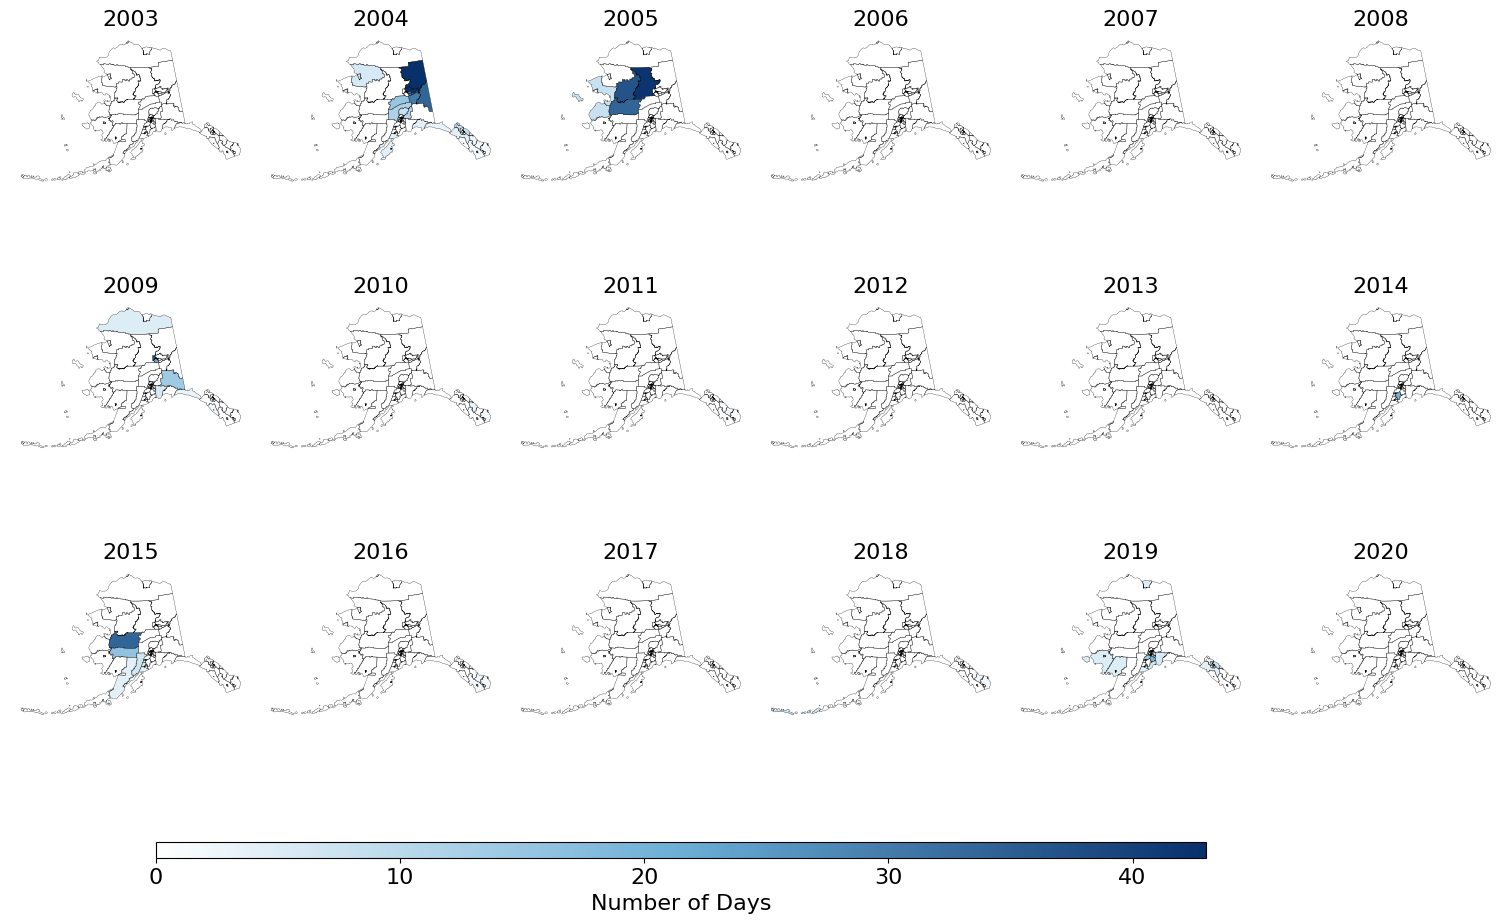

Figure saved successfully to /mnt/c/Users/nrathauda/OneDrive - University of Alaska/NIMHD K01 - wildfire and birth outcomes/Alaska_wildfire-smoke-metrics_2025/Output/WFS_M5_Panel.png


In [9]:
# Number of rows and columns for the panel
num_rows = 3
num_cols = 6

# Create a figure and GeoAxes with the Albers Equal Area projection
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
fig, axes = plt.subplots(num_rows, num_cols, subplot_kw={'projection': alaska_albers}, figsize=(15, 8), constrained_layout=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each year
for i, year in enumerate(years):
    
    # Plotting the shapefile with a color based on Avg_PM25 values for the specific year
    WFS_M5_Annual_Tract_wGeo.plot(ax=axes[i], column=year, cmap=WhiteToBlue, transform=alaska_albers, legend=False, vmin=vmin, vmax=vmax)

    # Add thin black border to the shapefile data
    WFS_M5_Annual_Tract_wGeo.boundary.plot(ax=axes[i], color='black', linewidth=0.20, transform=alaska_albers)

    # Set plot title
    axes[i].set_title(f"{year}", fontsize=16)

    # Remove axes ticks and labels
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])

    # Remove frame around each subplot
    axes[i].axis('off')
    
# Generate tick positions for colorbar
ticks = np.arange(0, vmax + 10, 10)

# Generate a single colorbar for all plots
cbar_ax = fig.add_axes([0.1, -0.1, 0.7, 0.02])  # Adjust the width of the colorbar here
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=WhiteToBlue),
                    cax=cbar_ax, orientation='horizontal', ticks=ticks)
cbar.set_label('Number of Days', fontsize=16)  # Increase title size
cbar_ax.tick_params(labelsize=16)  # Increase tick label size

# Draw the figure to ensure everything is properly rendered
plt.draw()

# Export
output_file_path = f"{output_folder}/WFS_M5_Panel.png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

# Show the figure in the notebook
plt.show()
print(f"Figure saved successfully to {output_file_path}")